In [ ]:
#!pip install imgaug # with imgaug everything complicated on collab. Try to uninstall it first and then install.

In [ ]:
!pip install pillow --upgrade

Requirement already up-to-date: pillow in /usr/local/lib/python3.7/dist-packages (8.2.0)


In [ ]:
!pip install torchvision --upgrade

Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


In [ ]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:80% !important;}</style>'))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms, utils
import torchvision.models as models
import torchvision

import numpy as np
from tqdm import tqdm
from queue import Empty, Queue
from threading import Thread
import threading
from torch.autograd import Variable
from sklearn.utils import shuffle
import pickle
import sys
import os
import matplotlib.pyplot as plt
from matplotlib import cm

# augmentation library
from imgaug.augmentables import Keypoint, KeypointsOnImage
import imgaug.augmenters as iaa
from PIL import Image
import gc
import pandas as pd

from typing import Tuple, List, Type, Dict, Any

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
num_epochs = 3
use_gpu = True
batch_size = 40
images_base_dir = '/content/drive/.shortcut-targets-by-id/1iT_VL0DN282dlWNQq0PKG8x_vA2CWElT/train/'

In [ ]:
class thread_killer(object):    
    """Boolean object for signaling a worker thread to terminate
    Once a thread is launched, it should be terminated at some moment.
    In case the function of this thread is an infinite loop, one needs a mutex
    for signaling a worker thread to break the loop.
    The fuction will return, and the thread will be terminated.
    """
    
    def __init__(self):
        self.to_kill = False

    def __call__(self):
        return self.to_kill

    def set_tokill(self, tokill):
        self.to_kill = tokill

In [ ]:
class Threadsafe_iter:
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)

def get_objects_i(objects_count):
    """Cyclic generator of paths indices"""
    current_objects_id = 0
    while True:
        yield current_objects_id
        current_objects_id  = (current_objects_id + 1) % objects_count

In [ ]:
def val_train_split(pkl_file):
    with open(pkl_file, 'rb') as f:
        marked_data_loaded = pickle.load(f)
    total_len = 0
    all_data = {i:[] for i in range(9)}
    for elem in marked_data_loaded:
        all_data[elem['observed_TCC']].append(elem)
        
    validation_data = []
    #####Validation data ######
    for i in range(9):
        val_len = 500
        validation_for_spec_TCC = np.random.choice(all_data[i], size=val_len)
        validation_data += list(validation_for_spec_TCC)
        print(type(np.array(all_data[i])[0]))
        print(type(np.array(validation_for_spec_TCC[0])))
        all_data[i] =  np.setdiff1d(np.array(all_data[i]), np.array(validation_for_spec_TCC))
    ###########################
    return all_data, validation_data


In [ ]:
def get_test_data(pkl_file):
    with open(pkl_file, 'rb') as f:
        marked_data_loaded = pickle.load(f)
    return marked_data_loaded

In [ ]:
class LandmarksDataset(Dataset):
    def __init__(self, pkl_file, root_dir, transform=None, batch_size = 8, augment = True, mode='train'):
        """
        Args:
            pkl_file (string): Path to the pkl file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            batch_size (int, optional): batch size
        """
        if mode=='train':
            self.return_y = True
        elif mode=='test':
            self.return_y = False
        else:
            raise ValueError("Mode can be only 'train' or 'test'")
        with open(pkl_file, 'rb') as f:
            marked_data_loaded = pickle.load(f)
        self.total_len = 0
        if self.return_y:
            self.all_data = {i:[] for i in range(9)}
            for elem in marked_data_loaded:
                self.all_data[elem['observed_TCC']].append(elem)
            self.landmarks_frame = []
            for i in range(9):
                mass_len = min(5000,len(self.all_data[i])) # change 5000(first number) to any desired number of objects of each TCC
                self.total_len += mass_len
                self.landmarks_frame += list(np.random.choice(self.all_data[i], size=mass_len))

        else:
            self.landmarks_frame = marked_data_loaded
        self.total_len = len(self.landmarks_frame)
        self.root_dir = root_dir
        self.transform = transform # This should be only applied to single image!
        #Transforms image to appropriate format for loaded torch nn
        #Read here: https://pytorch.org/hub/pytorch_vision_resnet/

        self.batch_size = batch_size


        self.lock = threading.Lock()
        self.yield_lock = threading.Lock()
        self.init_count = 0
        self.augment = augment
        if self.augment:
            # instantiate augmentations
            self.seq = torchvision.transforms.Compose([
                       torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
                       torchvision.transforms.RandomRotation(degrees=180),
                       torchvision.transforms.RandomHorizontalFlip(p=0.5),
                       torchvision.transforms.RandomVerticalFlip(p=0.5)
                       ])
            self.seq_2 = iaa.CoarseDropout(0.02, size_percent=0.5)
        else:
            self.seq = lambda images: images
            # iaa.meta.Identity() somehow doesn't work in colab version of imgaug .__.


    def __len__(self):
      return self.total_len

    def shuffle(self):
        if self.return_y:
            self.landmarks_frame = []
            for i in range(9):
                mass_len = min(5000,len(self.all_data[i])) # change 5000(first number) to any desired number of objects of each TCC
                self.total_len += mass_len
                self.landmarks_frame += list(np.random.choice(self.all_data[i], size=mass_len))
        self.objects_id_generator = Threadsafe_iter(get_objects_i(len(self.landmarks_frame)))
        self.landmarks_frame = shuffle(self.landmarks_frame)

    def __iter__(self):
        while True:
            with self.lock:
                if (self.init_count == 0):
                    self.shuffle()
                    self.imgs = []
                    self.y_train = []
                    self.init_count = 1
            for obj_id in self.objects_id_generator:
                #print(obj_id)
                img_name = os.path.join(self.root_dir,self.landmarks_frame[obj_id]['mission'],'snapshots',
                                        'snapshots-'+self.landmarks_frame[obj_id]['observations_dt'].strftime("%Y-%m-%d"),
                                        self.landmarks_frame[obj_id]['jpg_filename']) #check if correct path


                img = Image.open(img_name)
                #mask definition and application to image
                insert_img = np.full((img.width,img.height,3),0,dtype=np.uint8)
                mask_name = os.path.join(self.root_dir,self.landmarks_frame[obj_id]['mask_fname'])
                mask = Image.open(mask_name)
                mask = np.array(mask.resize((img.width,img.height)))
                mask = mask>0
                mask = Image.fromarray(np.uint8(mask*255))
                image = Image.composite(img, Image.fromarray(insert_img), mask) #applying mask
                mask.close()
                img.close()


                img_augmented = self.seq(image)
                img_augmented = self.seq_2.augment_images([np.array(img_augmented)])
                image = self.transform(np.array(img_augmented[0]))
                del img_augmented
                #print(sys.getsizeof(image))
                #image = self.transform(image)

                # Concurrent access by multiple threads to the lists below
                if self.return_y:
                    with self.yield_lock:
                        if (len(self.imgs)) < self.batch_size:
                            self.imgs.append(image)
                            self.y_train.append(self.landmarks_frame[obj_id]['observed_TCC'])
                        if len(self.imgs) % self.batch_size == 0:

                            gc.collect()
                            yield torch.stack(self.imgs,dim=0), torch.tensor(self.y_train)
                            self.imgs = []
                            self.y_train = []
                else:
                    with self.yield_lock:
                        if (len(self.imgs)) < self.batch_size:
                            self.imgs.append(image)
                            self.y_train.append(self.landmarks_frame[obj_id]['jpg_filename'])
                        if len(self.imgs) % self.batch_size == 0:
                            #imgs_f32 = np.float32(self.imgs)
                            yield torch.stack(self.imgs,dim=0), self.y_train
                            self.imgs = []
                            self.y_train = []
            # At the end of an epoch we re-init data-structures
            with self.lock:
                self.landmarks_frame = shuffle(self.landmarks_frame)
                self.init_count = 0

In [ ]:
class ToTensor(object):
    """Convert pillow images in sample to Tensors.
     Update: Here we also transform images to appropriate format for loaded nn input"""
    def __call__(self, sample):
        image = sample
        ###TODO: probably we should add to preprocess
        #Read here: https://pytorch.org/hub/pytorch_vision_resnet/
        preprocess = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Resize(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        return preprocess(image)


In [ ]:
dataset = LandmarksDataset(pkl_file=images_base_dir+'index.pkl',
                           root_dir=images_base_dir,
                           transform=ToTensor(),
                           batch_size=batch_size,augment=True)


In [ ]:
STEPS_PER_EPOCH = len(dataset)//batch_size + 1
STEPS_PER_EPOCH

1113

-----------------------------

In [ ]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Теперь загрузим предобученную модель. Список предварительно обученных моделей, доступных для использования в рамках `torchvision.models` можно посмотреть на странице документации: https://pytorch.org/vision/stable/models.html

Здесь мы загрузим AlexNet:

In [ ]:
resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Заметим, что AlexNet состоит из трех частей: сверточной (`features`), операции субдискретизации (`avgpool`) и полносвязного классификатора (`classifier`). Суть подхода Transfer Learning в том, чтобы заменить часть нейросети на новую и обучать её. Например, можно заменить полносвязную часть `classifier` на совершенно новую подсеть, которая, возможно, будет выполнять совершенно новую задачу - например, регрессию. При этом она будет использовать признаки, извлекаемые сверточной подсетью. При этом обычно свёрточную подсеть "замораживают", то есть, запрещают вычислять градиенты функции потерь по весам этой подсети. С нулевыми градиентами эти веса не меняются в процессе градиентной оптимизации вне зависимости от типа оптимизатора (лишь бы он был градиентный).

In [ ]:
for param in resnet50.parameters():
    param.requires_grad = True


resnet50.fc = torch.nn.Identity()

model = torch.nn.Sequential(resnet50,
                            nn.Linear(in_features=2048, out_features=9, bias=True)
)

Теперь на основе полученного модуля `alexnet`/`resnet` создадим новую нейросеть, в которой он будет всего лишь одним из преобразований.

In [ ]:
# Отправляем модель на устройство, на котором будут производиться вычисления
_ = model.to(device)

# Проверим, где располагается модель. Как минимум матрицы параметров.
for param in model.parameters():
    print(param.device)
    break

cuda:0


In [ ]:
def all_in_one_batches_feeder(tokill, batches_queue, dataset_generator):
    """
    Threaded worker for pre-processing input data.
    tokill (thread_killer): an object that indicates whether a thread should be terminated
    dataset_generator (Dataset): training/validation data generator
    batches_queue (Queue): a limited size thread-safe Queue instance for train/validation data batches
    """
    while tokill() == False:
        for sample_batch in dataset_generator:
            #print(sample_batch,type(sample_batch))
            X = sample_batch[0].to(device)
            y = sample_batch[1].to(device)
            batches_queue.put((X,y), block=True)
            if tokill() == True:
                return

-----------------

In [ ]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer,
                       loss_function: torch.nn.Module,
                       lr_scheduler: Any):
    model.train()

    loss_counter=0
    correct_counter=0

    # Initialize the loss function
    loss_fn = loss_function

    #for image_batch in tqdm(range(STEPS_PER_EPOCH), total=STEPS_PER_EPOCH):
    for image_batch in range(STEPS_PER_EPOCH):
        x, y = train_batches_queue.get(block=True) #train_cuda_batches_queue.get(block=True)

        # Here one usually implements training steps
        # apply model
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation  
        optimizer.zero_grad()
        loss.backward()
        #one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        # num_batches += 1
        loss = loss.item()
        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= len(x)
        correct_counter+=correct
        loss_counter+=loss

        frequency_of_report = 200
        if image_batch % frequency_of_report == 0:
          correct = correct_counter/frequency_of_report
          loss = loss_counter/frequency_of_report
          print(f"{image_batch}/{STEPS_PER_EPOCH} Accuracy: {(100*correct):>0.1f}%, loss: {loss:>7f} \n", flush=True)
          correct_counter=0
          loss_counter=0


        if image_batch % frequency_of_report == 0:
          lr_scheduler.step()

In [ ]:
def validate_single_epoch(model: torch.nn.Module,
                      loss_function: torch.nn.Module):
    model.eval()
    loss_fn = loss_function
    test_loss, correct = 0, 0
    with torch.no_grad():
        for image_batch in range(STEPS_PER_EPOCH):
            x, y = validate_batches_queue.get(block=True)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct /= len(x)
    test_loss /= STEPS_PER_EPOCH
    correct /= STEPS_PER_EPOCH
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n", flush = True)

In [ ]:
ls drive/MyDrive/

'Colab Notebooks'/   result.txt                    справка_о_составе_семьи.pdf
 for_collab/         всё_вместе.pdf               'Справка Паша.PDF'
 MPI/                свидетельство_о_разводе.pdf   Справки_о_доходах.PDF


In [ ]:
model.train()

# Here we instantiate queues and mutexes, and launch the threads that will preprocess the data and send it into GPU
#batches_queue_length = min(STEPS_PER_EPOCH, 40)


#train_cuda_batches_queue = Queue(maxsize=batches_queue_length)
train_thread_killer = thread_killer()
train_thread_killer.set_tokill(False)
preprocess_workers = 10
batches_queue_length = int(preprocess_workers)
train_batches_queue = Queue(maxsize=batches_queue_length)

for _ in range(preprocess_workers):
    thr = Thread(target=all_in_one_batches_feeder, args=(train_thread_killer, train_batches_queue, dataset))
    thr.start()

# Everything is ready for the training

print('Training ...', flush=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10)

for epoch in range(num_epochs):
    num_batches = 0
    correct = 0
    train_single_epoch(model, optimizer, loss_fn, lr_scheduler)

    if epoch==1:
        torch.save(model.state_dict(), "drive/MyDrive/model_1.pth")

    if epoch==2:
        torch.save(model.state_dict(), "drive/MyDrive/model_2.pth")

    if epoch==3:
        torch.save(model.state_dict(), "drive/MyDrive/model_3.pth")

torch.save(model.state_dict(), "drive/MyDrive/model.pth")


train_thread_killer.set_tokill(True)
#train_cuda_transfers_thread_killer.set_tokill(True)
for _ in range(batches_queue_length+preprocess_workers + 5):
    try:
        # Enforcing thread shutdown
        train_batches_queue.get(block=True,timeout=0.5)

    except:
        pass
del train_batches_queue
gc.collect()
torch.cuda.empty_cache()

Training ...
0/1113 Accuracy: 0.1%, loss: 0.010987 

200/1113 Accuracy: 42.3%, loss: 1.431494 

400/1113 Accuracy: 51.9%, loss: 1.191666 

600/1113 Accuracy: 57.8%, loss: 1.080764 

800/1113 Accuracy: 63.0%, loss: 0.957746 

1000/1113 Accuracy: 68.3%, loss: 0.851439 

0/1113 Accuracy: 0.4%, loss: 0.003994 

200/1113 Accuracy: 74.9%, loss: 0.700674 

400/1113 Accuracy: 78.4%, loss: 0.612264 

600/1113 Accuracy: 79.7%, loss: 0.578540 

800/1113 Accuracy: 80.0%, loss: 0.565410 

1000/1113 Accuracy: 80.9%, loss: 0.549743 

0/1113 Accuracy: 0.4%, loss: 0.002738 

200/1113 Accuracy: 80.0%, loss: 0.563851 

400/1113 Accuracy: 80.4%, loss: 0.541898 

600/1113 Accuracy: 79.7%, loss: 0.557168 

800/1113 Accuracy: 80.0%, loss: 0.544492 

1000/1113 Accuracy: 79.1%, loss: 0.581255 



In [ ]:
ls drive/MyDrive

'Colab Notebooks'/   model.pth        свидетельство_о_разводе.pdf
 for_collab/         MPI/             справка_о_составе_семьи.pdf
 model_1.pth         result.txt      'Справка Паша.PDF'
 model_2.pth         всё_вместе.pdf   Справки_о_доходах.PDF


In [ ]:
def put_obj_in_queue(tokill, batches_queue, dataset_generator):
    while tokill() == False:
        for sample_batch in dataset_generator:
            batches_queue.put((sample_batch[0].to(device),sample_batch[1]), block=True)
            if tokill() == True:
                return

def answer(test_dir, model, dataset):
    steps = len(dataset)//test_batch_size + 1
    model.eval()
    queue_length = 40
    train_queue = Queue(maxsize=queue_length)
    train_thread_killer = thread_killer()
    train_thread_killer.set_tokill(False)
    preprocess_workers = 60

    for _ in range(preprocess_workers):
        thr = Thread(target=put_obj_in_queue, args=(train_thread_killer, train_queue, dataset))
        thr.start()
    dict_for_return = {'jpg_filename':[], 'TCC':[]}
    with torch.no_grad():
        for image_batch in tqdm(range(steps), total=steps):
            x,name = train_queue.get(block=True)
            y_pred = model(x)
            _, predicted = torch.max(y_pred.data, 1)
            dict_for_return['jpg_filename'] += name
            dict_for_return['TCC'] += predicted.tolist()
            #print(i)
            #print(predicted.tolist())

    train_thread_killer.set_tokill(True)
    for _ in range(queue_length+preprocess_workers+1):
        try:
            # Enforcing thread shutdown
            #train_batches_queue.get(block=True, timeout=0.5)
            x,name = train_queue.get(block=True,timeout=0.5)
            y_pred = model(x)
            _, predicted = torch.max(y_pred.data, 1)
            dict_for_return['jpg_filename'] += name
            dict_for_return['TCC'] += predicted.tolist()
        except Empty:
            pass
    gc.collect() #delete all trash
    return dict_for_return
            
    

In [ ]:
model.load_state_dict(torch.load("drive/MyDrive/model_tmp.pth"))
test_batch_size=10
#test_dir = '/content/drive/MyDrive/for_collab/kaggle_clouds/test/'
test_dir = '/content/drive/.shortcut-targets-by-id/1Fnx7AJx-90ncp1diFHdcRHYsSofEMby5/test/'
dataset_val = LandmarksDataset(pkl_file=test_dir+'index.pkl',
                           root_dir=test_dir,                
                           transform=ToTensor(),
                           batch_size=test_batch_size,augment=True, mode='test')

In [ ]:
ans = answer(test_dir, model, dataset_val)


  0%|          | 0/2701 [00:00<?, ?it/s]
Exception in thread Thread-475:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-50-7e4844aa750b>", line 4, in put_obj_in_queue
    batches_queue.put((sample_batch[0].to(device),sample_batch[1]), block=True)
RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 14.76 GiB total capacity; 12.98 GiB already allocated; 11.75 MiB free; 13.71 GiB reserved in total by PyTorch)



RuntimeError: ignored

Exception in thread Thread-474:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-50-7e4844aa750b>", line 4, in put_obj_in_queue
    batches_queue.put((sample_batch[0].to(device),sample_batch[1]), block=True)
RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 14.76 GiB total capacity; 12.98 GiB already allocated; 11.75 MiB free; 13.71 GiB reserved in total by PyTorch)
Exception in thread Thread-447:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-50-7e4844aa750b>", line 4, in put_obj_in_queue
    batches_queue.put((sample_batch[0].to(device),sample_batch[1]), block=True)
R

In [ ]:
#Here answers on test saved to file which can be uploaded to kaggle
df = pd.DataFrame(ans).drop_duplicates(subset ="jpg_filename", keep = 'first')
df.to_csv('drive/MyDrive/result.csv',index=False)

In [ ]:
df

,jpg_filename,TCC
0,a20186e5-c307-4c3c-8c52-2e7af9ce1d1c.jpg,5
1,a2623c07-9ef3-4947-b9ce-2b20e4e6c37d.jpg,1
2,7b55958f-b459-4944-b00c-264478062b05.jpg,6
3,747da6bb-2e4d-42f4-92f5-c0daed2b330a.jpg,7
4,468ff098-118d-4bd9-af31-5d349b64afe7.jpg,1
...,...,...
26995,23ccd87b-86bc-4677-b2b0-6fe3edf24811.jpg,0
26996,3b320016-9a0f-4e0d-b5d0-19e94b15312e.jpg,5
26997,89d5bb07-8941-4798-b7cc-40b54274022e.jpg,6
26998,f6559cdc-cfc2-4190-a199-6d17a46dd26c.jpg,8


In [ ]:
class LandmarksDataset(Dataset):
    def __init__(self, pkl_file, root_dir, transform=None, batch_size = 8, augment = True, mode='train'):
        """
        Args:
            pkl_file (string): Path to the pkl file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            batch_size (int, optional): batch size
        """
        if mode=='train':
            self.return_y = True
        elif mode=='test':
            self.return_y = False
        else:
            raise ValueError("Mode can be only 'train' or 'test'")
        with open(pkl_file, 'rb') as f:
            marked_data_loaded = pickle.load(f)
        self.total_len = 0
        if self.return_y:
            self.all_data = {i:[] for i in range(9)}
            for elem in marked_data_loaded:
                self.all_data[elem['observed_TCC']].append(elem)
            self.landmarks_frame = []
            for i in range(9):
                mass_len = min(5000,len(self.all_data[i])) # change 5000(first number) to any desired number of objects of each TCC
                self.total_len += mass_len
                self.landmarks_frame += list(np.random.choice(self.all_data[i], size=mass_len))

        else:
            self.landmarks_frame = marked_data_loaded
        self.total_len = len(self.landmarks_frame)
        self.root_dir = root_dir
        self.transform = transform # This should be only applied to single image!
        #Transforms image to appropriate format for loaded torch nn
        #Read here: https://pytorch.org/hub/pytorch_vision_resnet/

        self.batch_size = batch_size


        self.lock = threading.Lock()
        self.yield_lock = threading.Lock()
        self.init_count = 0
        self.augment = augment
        if self.augment:
            # instantiate augmentations
            self.seq = torchvision.transforms.Compose([
                       torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
                       torchvision.transforms.RandomRotation(degrees=45),
                       torchvision.transforms.RandomHorizontalFlip(p=0.5),
                       torchvision.transforms.RandomVerticalFlip(p=0.5)
                       ])
            self.seq_2 = iaa.CoarseDropout(0.02, size_percent=0.5)
        else:
            self.seq = lambda images: images
            # iaa.meta.Identity() somehow doesn't work in colab version of imgaug .__.


    def __len__(self):
      return self.total_len

    def shuffle(self):
        if self.return_y:
            self.landmarks_frame = []
            for i in range(9):
                mass_len = min(5000,len(self.all_data[i])) # change 5000(first number) to any desired number of objects of each TCC
                self.total_len += mass_len
                self.landmarks_frame += list(np.random.choice(self.all_data[i], size=mass_len))
        self.objects_id_generator = Threadsafe_iter(get_objects_i(len(self.landmarks_frame)))
        self.landmarks_frame = shuffle(self.landmarks_frame)

    def __iter__(self):
        while True:
            with self.lock:
                if (self.init_count == 0):
                    self.shuffle()
                    self.imgs = []
                    self.y_train = []
                    self.init_count = 1
            for obj_id in self.objects_id_generator:
                #print(obj_id)
                img_name = os.path.join(self.root_dir,self.landmarks_frame[obj_id]['mission'],'snapshots',
                                        'snapshots-'+self.landmarks_frame[obj_id]['observations_dt'].strftime("%Y-%m-%d"),
                                        self.landmarks_frame[obj_id]['jpg_filename']) #check if correct path


                img = Image.open(img_name)
                #mask definition and application to image
                insert_img = np.full((img.width,img.height,3),0,dtype=np.uint8)
                mask_name = os.path.join(self.root_dir,self.landmarks_frame[obj_id]['mask_fname'])
                mask = Image.open(mask_name)
                mask = np.array(mask.resize((img.width,img.height)))
                mask = mask>0
                mask = Image.fromarray(np.uint8(mask*255))
                image = Image.composite(img, Image.fromarray(insert_img), mask) #applying mask
                mask.close()
                img.close()


                img_augmented = self.seq(image)
                img_augmented = self.seq_2.augment_images([np.array(img_augmented)])
                image = self.transform(np.array(img_augmented[0]))
                del img_augmented
                #print(sys.getsizeof(image))
                #image = self.transform(image)

                # Concurrent access by multiple threads to the lists below
                if self.return_y:
                    with self.yield_lock:
                        if (len(self.imgs)) < self.batch_size:
                            self.imgs.append(image)
                            self.y_train.append(self.landmarks_frame[obj_id]['observed_TCC'])
                        if len(self.imgs) % self.batch_size == 0:
                            gc.collect()
                            yield torch.stack(self.imgs,dim=0), torch.tensor(self.y_train)
                            self.imgs = []
                            self.y_train = []
                else:
                    with self.yield_lock:
                        if (len(self.imgs)) < self.batch_size:
                            self.imgs.append(image)
                            self.y_train.append(self.landmarks_frame[obj_id]['jpg_filename'])
                        if len(self.imgs) % self.batch_size == 0:
                            #imgs_f32 = np.float32(self.imgs)
                            yield torch.stack(self.imgs,dim=0), self.y_train
                            self.imgs = []
                            self.y_train = []
            # At the end of an epoch we re-init data-structures
            with self.lock:
                self.landmarks_frame = shuffle(self.landmarks_frame)
                self.init_count = 0

In [ ]:
class ToTensor(object):
    """Convert pillow images in sample to Tensors.        transforms.Resize(224),
     Update: Here we also transform images to appropriate format for loaded nn input"""
    def __call__(self, sample):
        image = sample
        #Read here: https://pytorch.org/hub/pytorch_vision_resnet/
        preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        return preprocess(image)

In [ ]:
dataset = LandmarksDataset(pkl_file=images_base_dir+'index.pkl',
                           root_dir=images_base_dir,
                           transform=ToTensor(),
                           batch_size=1, augment=True)

(512, 512, 3)
(1, 512, 512, 3)
<class 'torch.Tensor'>


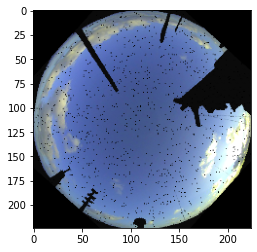

In [ ]:
for sample_batch in dataset:
    print(type(sample_batch[0]))
    plt.imshow(sample_batch[0].squeeze().transpose(0,1).transpose(1,2))
    break